In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS08a-009.h5"

In [3]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [4]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (8608386, 4)
X_s shape: (8608386, 14)
X_v shape: (8608386, 14)
T shape: (8608386, 10)
A shape: (8608386, 4)


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


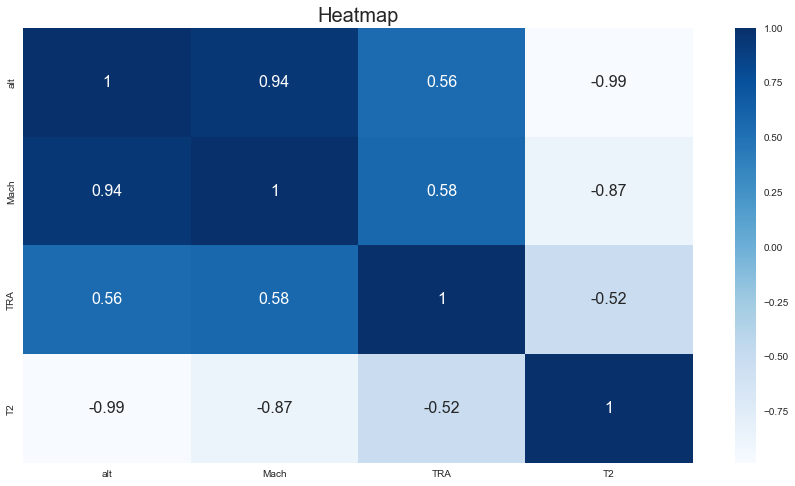

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle
0,632.830608,1525.667253,1953.949543,1319.505339,20.431550,14.614995,20.742691,26.314587,448.927946,455.757278,16.731336,2271.183351,8867.826621,5.534608,1.0,3003.0,0.392490,84.286507,523.610932,1.0
1,632.859504,1525.696748,1953.927850,1319.441504,20.433361,14.616348,20.744529,26.317586,448.944360,455.774913,16.729315,2271.271698,8867.930859,5.534581,1.0,3008.0,0.392994,84.286507,523.633379,1.0
2,632.889882,1525.725093,1953.948358,1319.424113,20.435964,14.618606,20.747172,26.321283,448.970022,455.801296,16.728307,2271.312307,8868.013734,5.534890,1.0,3012.0,0.393561,84.286507,523.662756,1.0
3,632.920333,1525.759185,1953.952618,1319.375074,20.437438,14.619858,20.748668,26.323778,448.979763,455.811807,16.725681,2271.397942,8868.125342,5.534886,1.0,3020.0,0.394254,84.286507,523.689414,1.0
4,632.956016,1525.785508,1953.952454,1319.329057,20.440027,14.622166,20.751297,26.327640,448.994394,455.827309,16.723509,2271.452480,8868.204160,5.534968,1.0,3026.0,0.394947,84.286507,523.723272,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608381,577.528601,1321.635848,1578.592550,1160.810649,16.564442,13.615548,16.816692,19.501735,265.849007,270.801149,14.538697,1777.137884,8193.388620,2.647037,15.0,3024.0,0.230769,39.111050,513.294209,72.0
8608382,577.077169,1320.376511,1577.167980,1160.792675,16.537771,13.606607,16.789615,19.453720,264.960398,269.890748,14.538870,1772.360892,8188.766122,2.636919,15.0,3016.0,0.227745,38.847378,513.183341,72.0
8608383,577.033125,1319.865538,1576.629413,1160.848177,16.547822,13.627178,16.799819,19.455395,264.648662,269.573484,14.540629,1769.640210,8186.708495,2.633749,15.0,3012.0,0.231966,38.671600,513.397445,72.0
8608384,577.038478,1319.659073,1576.255366,1160.765037,16.555576,13.639659,16.807691,19.460436,264.541989,269.465845,14.543199,1768.468579,8185.866405,2.632082,15.0,3006.0,0.234234,38.583710,513.521326,72.0


In [8]:
#selezione unita e ciclo
unit=1
cycle=10

<Figure size 432x288 with 0 Axes>

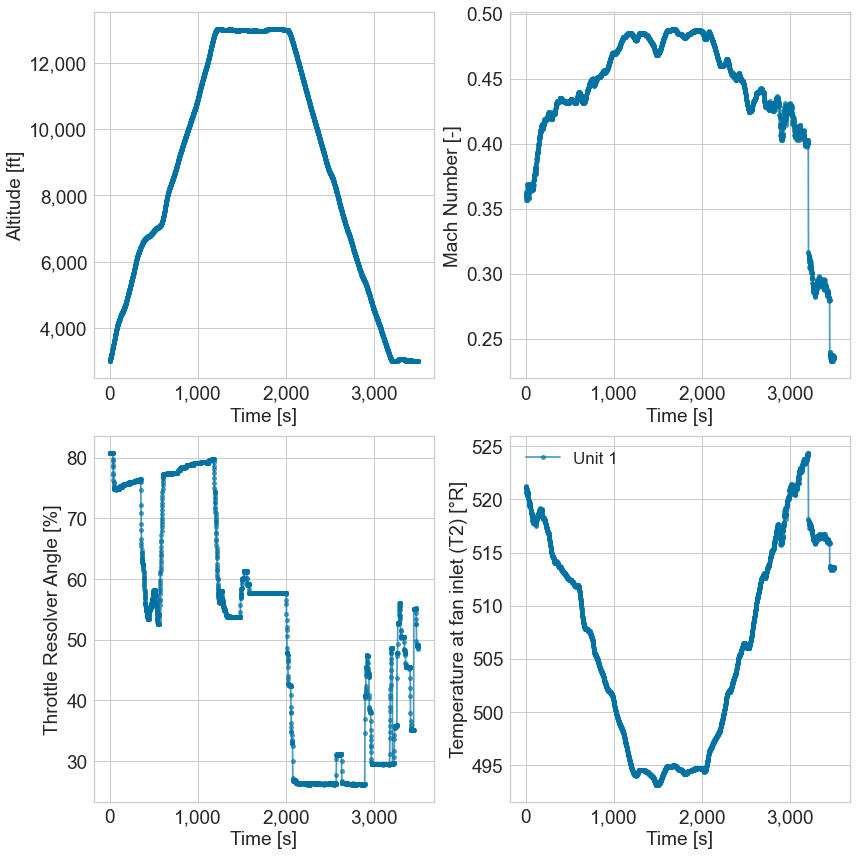

In [9]:
filter1 = df_X_s[df_X_s['unit']==unit]
filter1 = filter1[filter1['cycle']==cycle]
filter1.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
x = np.array(np.arange(len(df_X_s)))
y = np.array(df_X_s['alt'].to_list())

# calcolare la derivata
dy_dx = np.gradient(y, x)

# trovare i punti stazionari
stationary_points = x[np.where(dy_dx == 0)[0]]

print(stationary_points)

df_X_s = df_X_s.iloc[stationary_points]
df_X_s.reset_index(inplace=True)

[    768     781     782 ... 8607837 8608354 8608370]


<Figure size 432x288 with 0 Axes>

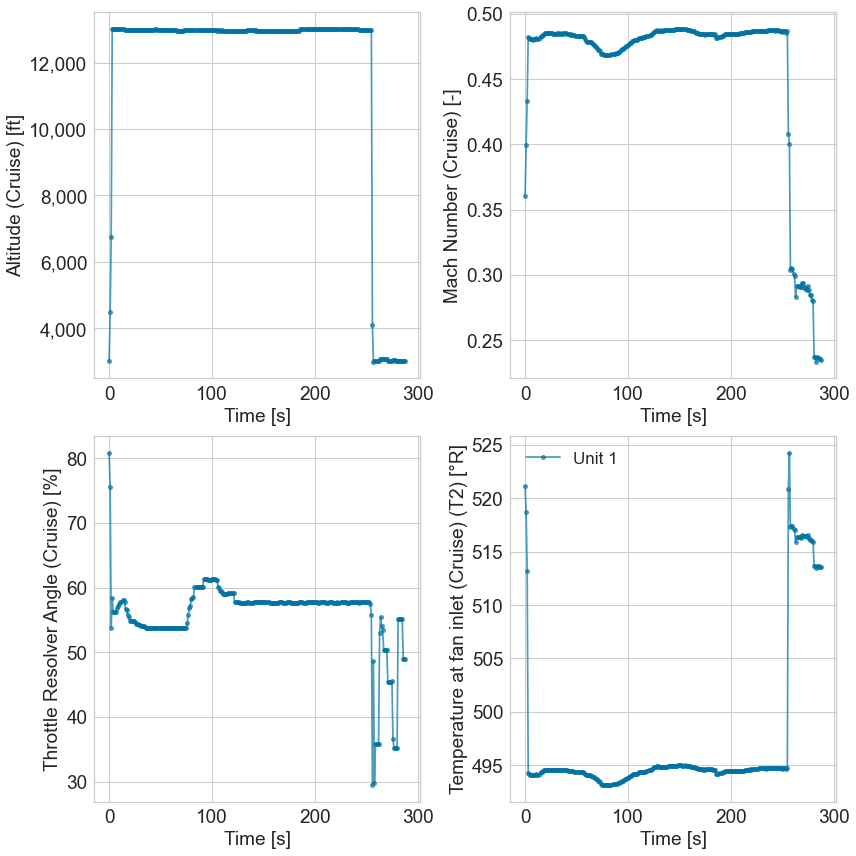

In [11]:
filter2 = df_X_s[df_X_s['unit']==unit]
filter2 = filter2[filter2['cycle']==cycle]
filter2.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

## CLUSTERING

-9.875221225696305e-17 1.0000000000000002
(1037443, 19)


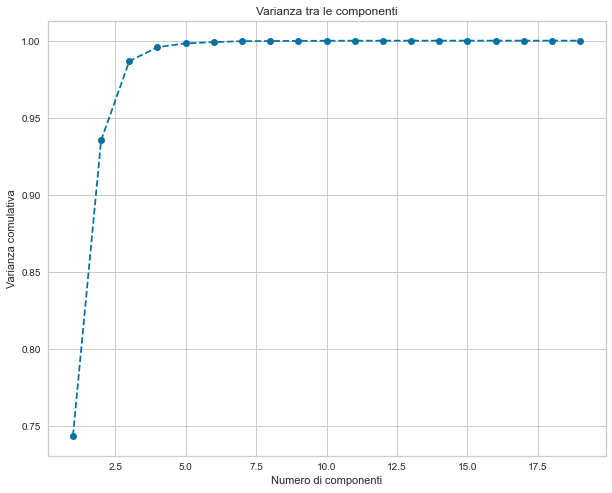

In [12]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit",'cycle']))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 2


KMeans(n_clusters=2, random_state=42)

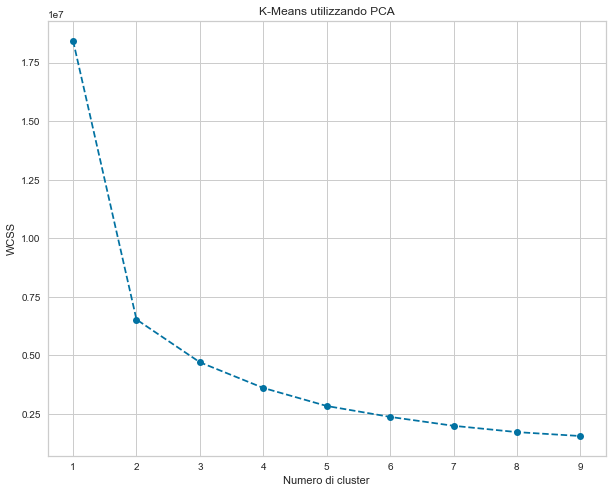

In [13]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(scores_pca)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

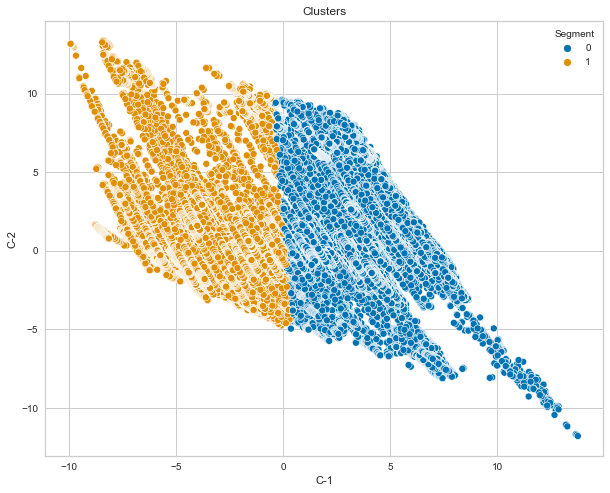

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,unit,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment
0,768,604.546838,1450.664099,1839.233453,1233.656579,15.841668,11.509471,16.082912,20.325986,336.629489,...,1.0,11091.0,0.505575,80.331459,503.610800,1.0,6.813870,-7.123058,0,0
1,781,605.336673,1451.843989,1840.588312,1234.115879,15.907621,11.562428,16.149869,20.414995,337.675879,...,1.0,11104.0,0.513072,80.331459,504.296214,1.0,6.884346,-7.190052,0,0
2,782,605.481085,1452.089316,1840.748917,1234.126228,15.920283,11.571942,16.162724,20.432212,337.901683,...,1.0,11103.0,0.514269,80.331459,504.412929,1.0,6.897912,-7.202219,0,0
3,787,605.750875,1452.459376,1840.930268,1234.018967,15.941419,11.588112,16.184181,20.462044,338.216156,...,1.0,11108.0,0.516537,80.331459,504.623629,1.0,6.917506,-7.220790,0,0
4,790,605.920257,1452.724008,1841.183962,1234.086612,15.956022,11.599490,16.199007,20.481874,338.459620,...,1.0,11108.0,0.517986,80.331459,504.765184,1.0,6.933253,-7.234953,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037438,8607833,576.799327,1326.549010,1594.673553,1156.974022,15.871995,12.930107,16.113700,18.905746,262.905936,...,15.0,5123.0,0.302400,43.681328,509.552464,72.0,4.172260,2.764095,0,0
1037439,8607836,576.802436,1326.566203,1594.730512,1157.029233,15.872987,12.930866,16.114707,18.906789,262.929157,...,15.0,5120.0,0.302274,43.681328,509.555733,72.0,4.174288,2.763260,0,0
1037440,8607837,576.792906,1326.553496,1594.696594,1157.001963,15.871830,12.929685,16.113533,18.905417,262.916062,...,15.0,5121.0,0.302148,43.681328,509.544399,72.0,4.173066,2.764103,0,0
1037441,8608354,579.887984,1332.073093,1599.378848,1169.251467,16.679898,13.621637,16.933906,19.743525,273.626119,...,15.0,3097.0,0.240345,41.571968,513.491801,72.0,5.226903,2.853112,0,0


In [14]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [15]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-1.0713762267000665e-16 0.9999999999999998
(506108, 21)
-7.310505344305526e-16 1.0000000000000002
(531335, 21)


,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle,group
mean,4.003059e+06,580.529836,1350.413432,1652.013551,1155.732218,14.881736,11.770096,15.108361,18.137706,265.716864,...,1933.011981,8301.752003,2.810922,7.815253,9975.801845,0.460432,54.121854,504.25132,33.707709,0.0
mean,4.636299e+06,552.450013,1312.694129,1638.268548,1090.261214,9.699138,7.300411,9.846840,12.281467,191.250087,...,2037.179279,8182.602466,2.051884,8.931949,25231.756316,0.663964,72.177631,466.60166,29.453565,1.0


Text(0, 0.5, 'Flight Class # [-]')

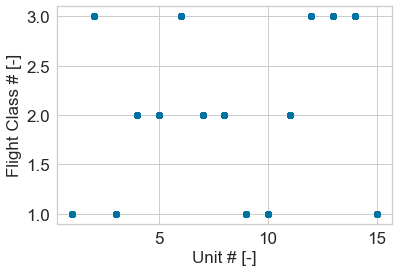

In [16]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [17]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 1,
 2: 3,
 3: 1,
 4: 2,
 5: 2,
 6: 3,
 7: 2,
 8: 2,
 9: 1,
 10: 1,
 11: 2,
 12: 3,
 13: 3,
 14: 3,
 15: 1}

In [18]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment,class
0,768,604.546838,1450.664099,1839.233453,1233.656579,15.841668,11.509471,16.082912,20.325986,336.629489,...,11091.0,0.505575,80.331459,503.610800,1.0,6.813870,-7.123058,0,0,1
1,781,605.336673,1451.843989,1840.588312,1234.115879,15.907621,11.562428,16.149869,20.414995,337.675879,...,11104.0,0.513072,80.331459,504.296214,1.0,6.884346,-7.190052,0,0,1
2,782,605.481085,1452.089316,1840.748917,1234.126228,15.920283,11.571942,16.162724,20.432212,337.901683,...,11103.0,0.514269,80.331459,504.412929,1.0,6.897912,-7.202219,0,0,1
3,787,605.750875,1452.459376,1840.930268,1234.018967,15.941419,11.588112,16.184181,20.462044,338.216156,...,11108.0,0.516537,80.331459,504.623629,1.0,6.917506,-7.220790,0,0,1
4,790,605.920257,1452.724008,1841.183962,1234.086612,15.956022,11.599490,16.199007,20.481874,338.459620,...,11108.0,0.517986,80.331459,504.765184,1.0,6.933253,-7.234953,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037438,8607833,576.799327,1326.549010,1594.673553,1156.974022,15.871995,12.930107,16.113700,18.905746,262.905936,...,5123.0,0.302400,43.681328,509.552464,72.0,4.172260,2.764095,0,0,1
1037439,8607836,576.802436,1326.566203,1594.730512,1157.029233,15.872987,12.930866,16.114707,18.906789,262.929157,...,5120.0,0.302274,43.681328,509.555733,72.0,4.174288,2.763260,0,0,1
1037440,8607837,576.792906,1326.553496,1594.696594,1157.001963,15.871830,12.929685,16.113533,18.905417,262.916062,...,5121.0,0.302148,43.681328,509.544399,72.0,4.173066,2.764103,0,0,1
1037441,8608354,579.887984,1332.073093,1599.378848,1169.251467,16.679898,13.621637,16.933906,19.743525,273.626119,...,3097.0,0.240345,41.571968,513.491801,72.0,5.226903,2.853112,0,0,1


In [19]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       1     202532
1       3     155748
2       2     147828
totale cluster 0 : 506108
cluster 1
   Classe  Conteggio
0       3     368382
1       2     161445
2       1       1508
totale cluster 1 : 531335
cluster 2
Empty DataFrame
Columns: [Classe, Conteggio]
Index: []
totale cluster 2 : 0


In [20]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 10099.0
max: 29018.0
